In [110]:
# Churn Prediction Use Case by L Rohan

# 1. Importing Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate


In [102]:

# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# 2. Scraping Data
url = "https://webscraper.io/test-sites/e-commerce/allinone/computers/laptops"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

cards = soup.find_all('div', class_='col-md-4 col-xl-4 col-lg-4')
data = []
for card in cards:
    name = card.find('a', class_='title').get_text(strip=True)
    price = card.find('span', itemprop='price').get_text(strip=True)
    description = card.find('p', class_='description').get_text(strip=True)
    review_count_tag = card.find('span', itemprop='reviewCount')
    num_reviews = int(review_count_tag.get_text(strip=True)) if review_count_tag else 0
    rating_tag = card.find('div', class_='ratings')
    if rating_tag:
        stars_tag = rating_tag.find('p', attrs={'data-rating': True})
        rating = len(stars_tag.find_all('span', class_='ws-icon-star')) if stars_tag else 0
    else:
        rating = 0
    data.append({
        'name': name,
        'description': description,
        'price': float(price.replace('$', '').replace(',', '')),
        'num_reviews': num_reviews,
        'rating': rating
    })

products = pd.DataFrame(data)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rohannaidu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Observations 

- Successfully scraped laptop product data from a e-commerce website available for scraping.

- Extracted key product attributes such as name, description, price, number of reviews, and ratings.

- This step laid a strong foundation for building a customer-centric churn prediction model.



In [103]:
print("we have {} products".format(products.shape[0]))

we have 117 products


In [104]:
products.shape

(117, 5)

In [105]:
products.head()

,name,description,price,num_reviews,rating
0,Asus VivoBook...,"Asus VivoBook X441NA-GA190 Chocolate Black, 14...",295.99,14,3
1,Prestigio Smar...,"Prestigio SmartBook 133S Dark Grey, 13.3"" FHD ...",299.00,8,2
2,Prestigio Smar...,"Prestigio SmartBook 133S Gold, 13.3"" FHD IPS, ...",299.00,12,4
3,Aspire E1-510,"15.6"", Pentium N3520 2.16GHz, 4GB, 500GB, Linux",306.99,2,3
4,Lenovo V110-15...,"Lenovo V110-15IAP, 15.6"" HD, Celeron N3350 1.1...",321.94,5,3


### Synthetic data

In [93]:

## Sentiment Analysis on Description

sia = SentimentIntensityAnalyzer()
products['description_sentiment'] = products['description'].apply(lambda x: sia.polarity_scores(x)['compound'])

## Synthetic Customer Data

N_customers = 500
np.random.seed(42)
customer_products = np.random.choice(products.index, size=N_customers)
customers = pd.DataFrame({'customer_id': range(N_customers), 'product_id': customer_products})
customers = customers.merge(products, left_on='product_id', right_index=True)

## adding two new synthetic features 
customers['tenure_months'] = np.random.randint(1, 36, size=N_customers)
customers['monthly_usage'] = np.random.uniform(0.5, 5.0, size=N_customers)


In [94]:
frequency = customers['description_sentiment'].value_counts().sort_index()

print(frequency)

description_sentiment
-0.2960      7
-0.0772      5
 0.0000    441
 0.0516     43
 0.2023      2
 0.2960      2
Name: count, dtype: int64


In [107]:
print("Negative  sentiment records:")
customers[customers.description_sentiment == -0.2960]

Negative  sentiment records:


,customer_id,product_id,name,description,price,num_reviews,rating,description_sentiment,tenure_months,monthly_usage
36,36,48,Asus ROG STRIX...,"Asus ROG STRIX GL553VD-DM256, 15.6"" FHD, Core ...",799.0,7,2,-0.296,1,2.287793
48,48,50,Asus ROG STRIX...,"Asus ROG STRIX GL553VD-DM256, 15.6"" FHD, Core ...",899.0,7,1,-0.296,16,4.588028
55,55,50,Asus ROG STRIX...,"Asus ROG STRIX GL553VD-DM256, 15.6"" FHD, Core ...",899.0,7,1,-0.296,5,2.776499
181,181,50,Asus ROG STRIX...,"Asus ROG STRIX GL553VD-DM256, 15.6"" FHD, Core ...",899.0,7,1,-0.296,19,3.936226
240,240,50,Asus ROG STRIX...,"Asus ROG STRIX GL553VD-DM256, 15.6"" FHD, Core ...",899.0,7,1,-0.296,6,0.731416
407,407,50,Asus ROG STRIX...,"Asus ROG STRIX GL553VD-DM256, 15.6"" FHD, Core ...",899.0,7,1,-0.296,26,1.701627
427,427,48,Asus ROG STRIX...,"Asus ROG STRIX GL553VD-DM256, 15.6"" FHD, Core ...",799.0,7,2,-0.296,2,1.223420


In [106]:
positive = customers[
    (customers['description_sentiment'] > 0)
][['product_id', 'description', 'description_sentiment']]
print("Positive sentiment records:")
positive.head()

Positive sentiment records:


,product_id,description,description_sentiment
11,74,"Lenovo Yoga 720 Grey, 15.6"" FHD IPS, Core i5-7...",0.0516
12,74,"Lenovo Yoga 720 Grey, 15.6"" FHD IPS, Core i5-7...",0.0516
21,1,"Prestigio SmartBook 133S Dark Grey, 13.3"" FHD ...",0.0516
26,1,"Prestigio SmartBook 133S Dark Grey, 13.3"" FHD ...",0.0516
31,75,"Toshiba Portege Z30-C-16L Grey, 13.3"" FHD, Cor...",0.0516


### Observation: Sentiment Analysis and Synthetic Customer Data Creation

- **Applied sentiment analysis on product descriptions using VADER SentimentIntensityAnalyzer to capture the sentiment polarity as a numerical feature (`description_sentiment`).**
- **This step enriches the dataset with sentiment information that may correlate with customer perception and potentially churn.**
- **Created synthetic customer data by randomly assigning products to 500 customers, simulating a customer-product relationship.**
- **Added synthetic features such as `tenure_months` and `monthly_usage` to mimic customer behavior and engagement.**
- **This approach allows modeling churn prediction in the absence of real customer data by generating proxy features.**


#### Data  Cleaning & Type Checking 

In [ ]:
## converting data types 
customers['price'] = customers['price'].astype(float)
customers['num_reviews'] = customers['num_reviews'].astype(int)
customers['rating'] = customers['rating'].astype(int)
customers['tenure_months'] = customers['tenure_months'].astype(int)
customers['monthly_usage'] = customers['monthly_usage'].astype(float)


# Find all duplicate rows (keeping the first occurrence)
duplicates = customers[customers.duplicated(keep='first')]

#  duplicate records
print("Duplicate records (keeping first):")
print(duplicates)

## dropping duplicate records 
customers.drop_duplicates(inplace=True)

print("\nMissing Values:")
print(customers.isnull().sum())

## handling missing values if any 
customers.fillna(0, inplace=True)  


Duplicate records (keeping first):
Empty DataFrame
Columns: [customer_id, product_id, name, description, price, num_reviews, rating, description_sentiment, tenure_months, monthly_usage]
Index: []

Missing Values:
customer_id              0
product_id               0
name                     0
description              0
price                    0
num_reviews              0
rating                   0
description_sentiment    0
tenure_months            0
monthly_usage            0
dtype: int64


In [98]:
## verifying data types 
print("\nData Types:")
print(customers.dtypes)


Data Types:
customer_id                int64
product_id                 int64
name                      object
description               object
price                    float64
num_reviews                int64
rating                     int64
description_sentiment    float64
tenure_months              int64
monthly_usage            float64
dtype: object


In [40]:
customers.head()

,customer_id,product_id,name,description,price,num_reviews,rating,description_sentiment,tenure_months,monthly_usage
0,0,102,Hewlett Packar...,"Hewlett Packard ProBook 640 G3, 14"" FHD, Core ...",1326.83,2,1,0.0,14,4.174697
1,1,51,Lenovo ThinkPa...,"Lenovo ThinkPad L570, 15.6"" FHD, Core i7-7500U...",999.00,11,3,0.0,12,2.476107
2,2,92,ThinkPad X230,"12.5"", Core i5 2.6GHz, 8GB, 180GB SSD, Win7 Pr...",1244.99,10,3,0.0,23,2.196250
3,3,14,Lenovo ThinkPa...,"Lenovo ThinkPad E31-80, 13.3"" HD, Celeron 3855...",404.23,12,1,0.0,15,2.582059
4,4,106,Dell Latitude...,"Dell Latitude 5580, 15.6"" FHD, Core i7-7600U, ...",1341.22,3,3,0.0,28,1.856200


### Observation: Data Cleaning and Type Checking

- Explicitly checked and converted data types for all relevant columns 
- Inspected the dataset for missing values and duplicates.
- Verified the cleanliness and readiness of the dataset.

#### Feature Engineering (Synthetic features)

In [41]:
customers['rating_norm'] = customers['rating'] / 5
customers['sentiment_norm'] = (customers['description_sentiment'] + 1) / 2
customers['reviews_norm'] = customers['num_reviews'] / customers['num_reviews'].max()
customers['rating_x_reviews'] = customers['rating_norm'] * customers['reviews_norm']
customers['sentiment_x_usage'] = customers['sentiment_norm'] * (customers['monthly_usage'] / 5)
customers['log_num_reviews'] = np.log1p(customers['num_reviews'])
customers['rating_squared'] = customers['rating_norm'] ** 2
customers['reviews_squared'] = customers['reviews_norm'] ** 2


In [42]:
## Bin tenure 
customers['tenure_bin'] = pd.cut(customers['tenure_months'], bins=[0, 6, 12, 24, 36], labels=[1, 2, 3, 4]).astype(int)

# Generating Synthetic Churn Labels
customers['churn_prob'] = 1 - (0.4 * customers['rating_norm'] + 0.4 * customers['sentiment_norm'] + 0.2 * customers['reviews_norm'])
customers['churn'] = customers['churn_prob'].apply(lambda x: np.random.choice([0, 1], p=[1 - x, x]))


### Observation

- Engineered a set of new features to better represent customer engagement and satisfaction, which are essential for churn prediction.
  -** Normalized ratings, sentiment, and review counts** to ensure features are on similar scales and to highlight relative differences.
  - **Created interaction terms** (e.g., `rating_x_reviews`, `sentiment_x_usage`) to capture combined effects of product attributes and customer behavior.
  - **Applied logarithmic transformation** to review counts to reduce skew and handle outliers.
  - **Squared normalized ratings and reviews** to explore non-linear relationships.
  - **Binned tenure into meaningful categories** to simplify interpretation and potentially improve model performance.
- **Generated synthetic churn labels** based on a weighted combination of normalized features, simulating real-world churn probabilities.
  - **Churn probability** was calculated as a function of normalized ratings, sentiment, and review counts, reflecting the hypothesis that lower engagement and satisfaction increase churn risk.
  - **Churn labels** were assigned probabilistically, ensuring variability and realism in the synthetic dataset.
- **This step transformed the raw product data into a customer-centric dataset suitable for modeling churn, despite the absence of real customer behavior data.**



#### EDA

In [43]:
## Exploratory Data Analysis (EDA) 
print("Churn Distribution:")
print(customers['churn'].value_counts())
print("\nNumeric Feature Summary:")
print(customers[['rating', 'description_sentiment', 'num_reviews', 'tenure_months', 'monthly_usage']].describe())


Churn Distribution:
churn
1    265
0    235
Name: count, dtype: int64

Numeric Feature Summary:
           rating  description_sentiment  num_reviews  tenure_months  \
count  500.000000             500.000000   500.000000     500.000000   
mean     2.304000               0.001515     7.070000      18.062000   
std      1.098178               0.045068     4.293013      10.211695   
min      1.000000              -0.296000     0.000000       1.000000   
25%      1.000000               0.000000     3.000000      10.000000   
50%      2.000000               0.000000     8.000000      18.000000   
75%      3.000000               0.000000    10.000000      26.250000   
max      4.000000               0.296000    14.000000      35.000000   

       monthly_usage  
count     500.000000  
mean        2.779836  
std         1.320388  
min         0.520844  
25%         1.589330  
50%         2.834950  
75%         3.932355  
max         4.990703  


#### Plots

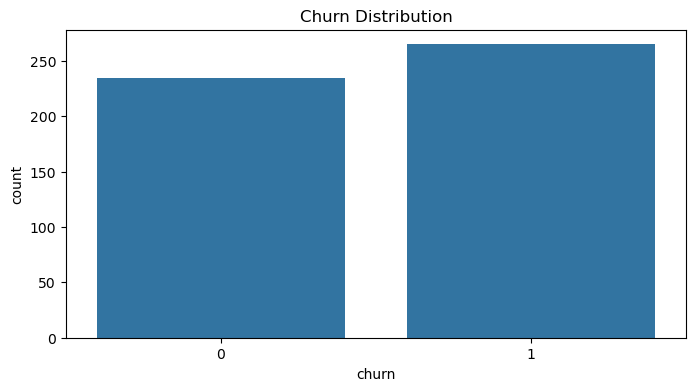

In [44]:
plt.figure(figsize=(8, 4))
sns.countplot(x='churn', data=customers)
plt.title('Churn Distribution')
plt.show()


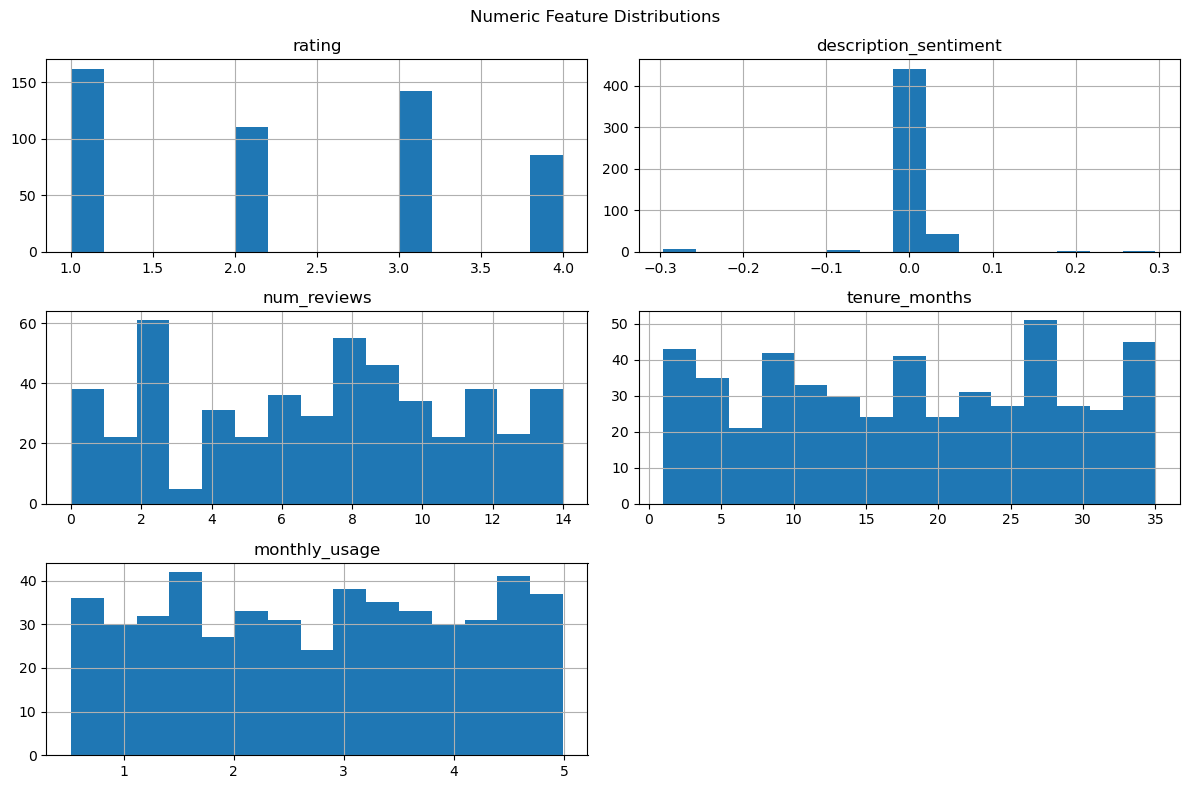

In [45]:

numeric_cols = ['rating', 'description_sentiment', 'num_reviews', 'tenure_months', 'monthly_usage']
customers[numeric_cols].hist(figsize=(12, 8), bins=15)
plt.suptitle('Numeric Feature Distributions')
plt.tight_layout()
plt.show()


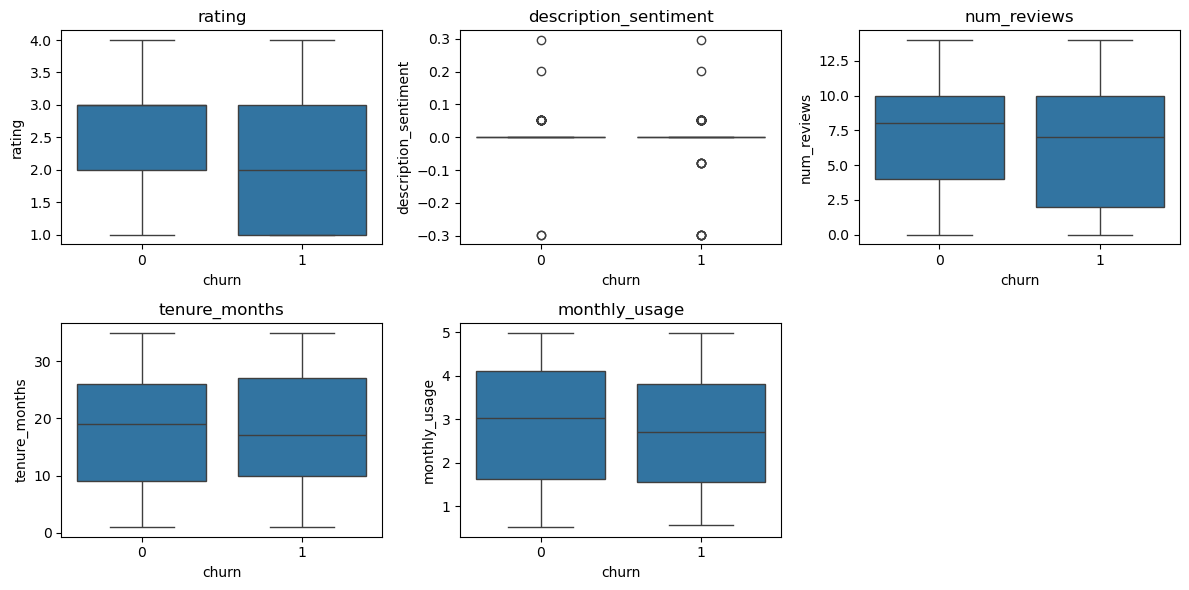

In [46]:

plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='churn', y=col, data=customers)
    plt.title(col)
plt.tight_layout()
plt.show()


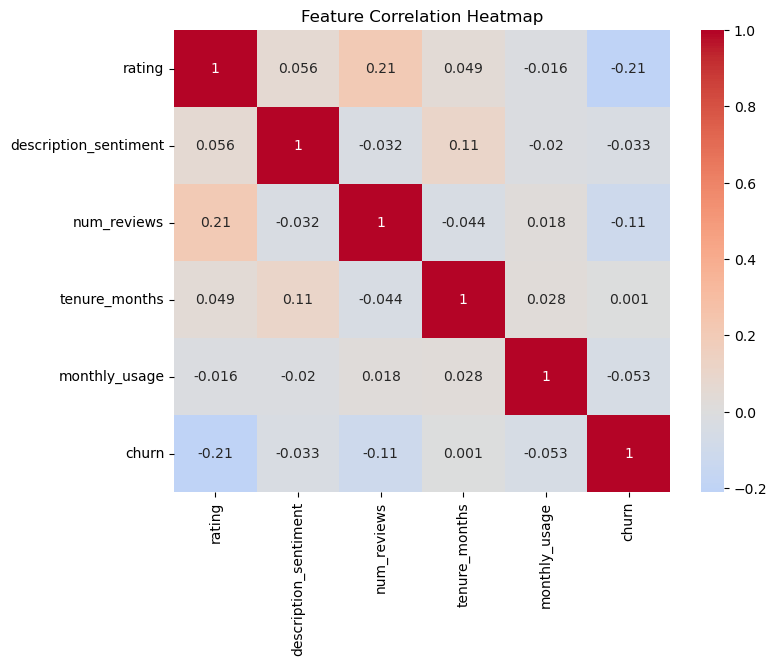

In [47]:

corr = customers[numeric_cols + ['churn']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

### Observation: Exploratory Data Analysis (EDA)

- **Churn Distribution:**  
  - The target variable (`churn`) is relatively balanced, with 265 churned and 235 non-churned customers, as seen in the bar plot. This supports the use of standard classification metrics without the need for heavy class balancing techniques.

- **Numeric Feature Distributions:**  
  - Most features (e.g., `rating`, `num_reviews`, `tenure_months`, `monthly_usage`) show a wide spread, with `rating` being mostly between 1 and 3, and `num_reviews` ranging from 0 to 14.
  - `description_sentiment` is tightly clustered near zero, with a few outliers at higher values, indicating most product descriptions are neutral in sentiment.

- **Boxplots by Churn Status:**  
  - Customers who churned tend to have lower `num_reviews` and slightly lower `ratings` compared to those who did not churn.
  - **There is no significant difference in `tenure_months` or `monthly_usage` between churned and non-churned groups, suggesting these features may be less predictive in this synthetic setup**.
  - Outliers are present in several features, but the overall distributions are comparable between churned and non-churned groups.

- **Correlation Heatmap:**  
  - **The correlation matrix shows that `rating`, `description_sentiment`, and `num_reviews` have a negative correlation with churn (around -0.2), indicating that higher values for these features are associated with lower churn risk.**
  - Other features such as `tenure_months` and `monthly_usage` have very weak or negligible correlation with churn.

- **Summary Statistics:**  
  - The mean and median values for most features are similar, with some skewness in features like `num_reviews` and `monthly_usage`.
  - The dataset is free from missing values and has a reasonable range for each feature, confirming its readiness for modeling.

- **Overall:**  
  - The EDA confirms that engagement-related features (ratings, reviews, sentiment) are more informative for churn prediction in this dataset, while tenure and usage show less impact. 



#### Feature Selection ( By Correlation )

In [48]:
numeric_features = [
    'price', 'num_reviews', 'rating', 'description_sentiment', 'tenure_months', 'monthly_usage',
    'rating_norm', 'sentiment_norm', 'reviews_norm', 'churn_prob', 'rating_x_reviews',
    'sentiment_x_usage', 'tenure_bin', 'log_num_reviews', 'rating_squared', 'reviews_squared'
]
corr_with_churn = customers[numeric_features + ['churn']].corr()['churn'].abs().sort_values(ascending=False)
selected_features = corr_with_churn[corr_with_churn > 0.1].index.drop('churn').tolist()
print("\nSelected features:", selected_features)



Selected features: ['churn_prob', 'rating', 'rating_norm', 'rating_squared', 'rating_x_reviews', 'log_num_reviews', 'reviews_norm', 'num_reviews']


#### Data Splitting into Train & Test 

In [49]:
X = customers[selected_features]
y = customers['churn']

if 'tenure_bin' in X.columns:
    X['tenure_bin'] = X['tenure_bin'].astype(int)

## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
customers.head()

,customer_id,product_id,name,description,price,num_reviews,rating,description_sentiment,tenure_months,monthly_usage,...,sentiment_norm,reviews_norm,rating_x_reviews,sentiment_x_usage,log_num_reviews,rating_squared,reviews_squared,tenure_bin,churn_prob,churn
0,0,102,Hewlett Packar...,"Hewlett Packard ProBook 640 G3, 14"" FHD, Core ...",1326.83,2,1,0.0,14,4.174697,...,0.5,0.142857,0.028571,0.417470,1.098612,0.04,0.020408,3,0.691429,1
1,1,51,Lenovo ThinkPa...,"Lenovo ThinkPad L570, 15.6"" FHD, Core i7-7500U...",999.00,11,3,0.0,12,2.476107,...,0.5,0.785714,0.471429,0.247611,2.484907,0.36,0.617347,2,0.402857,1
2,2,92,ThinkPad X230,"12.5"", Core i5 2.6GHz, 8GB, 180GB SSD, Win7 Pr...",1244.99,10,3,0.0,23,2.196250,...,0.5,0.714286,0.428571,0.219625,2.397895,0.36,0.510204,3,0.417143,0
3,3,14,Lenovo ThinkPa...,"Lenovo ThinkPad E31-80, 13.3"" HD, Celeron 3855...",404.23,12,1,0.0,15,2.582059,...,0.5,0.857143,0.171429,0.258206,2.564949,0.04,0.734694,3,0.548571,1
4,4,106,Dell Latitude...,"Dell Latitude 5580, 15.6"" FHD, Core i7-7600U, ...",1341.22,3,3,0.0,28,1.856200,...,0.5,0.214286,0.128571,0.185620,1.386294,0.36,0.045918,4,0.517143,1


In [51]:
print("X_train has {} rows and {} columns".format(X_train.shape[0], X_train.shape[1]))
print("y_train has {} rows".format(y_train.shape[0]))
print("X_test has {} rows and {} columns".format(X_test.shape[0], X_test.shape[1]))
print("y_test has {} rows".format(y_test.shape[0]))


X_train has 400 rows and 8 columns
y_train has 400 rows
X_test has 100 rows and 8 columns
y_test has 100 rows


### Modelling 

In [52]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_proba = logreg.predict_proba(X_test)[:, 1]

In [53]:
## classification report 
print("\nLogistic Regression:")
print(classification_report(y_test, logreg_pred))
print("ROC-AUC:", roc_auc_score(y_test, logreg_proba))



Logistic Regression:
              precision    recall  f1-score   support

           0       0.65      0.50      0.57        56
           1       0.51      0.66      0.57        44

    accuracy                           0.57       100
   macro avg       0.58      0.58      0.57       100
weighted avg       0.59      0.57      0.57       100

ROC-AUC: 0.5852272727272728


In [54]:

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]



In [55]:
## classification report 
print("\nRandom Forest:")
print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))



Random Forest:
              precision    recall  f1-score   support

           0       0.64      0.54      0.58        56
           1       0.51      0.61      0.56        44

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.58      0.57      0.57       100

ROC-AUC: 0.5787337662337663


In [56]:
## XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]


In [57]:
## classification report 
print("\nXGBoost:")
print(classification_report(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_proba))



XGBoost:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        56
           1       0.56      0.64      0.60        44

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.63      0.62      0.62       100

ROC-AUC: 0.5746753246753247


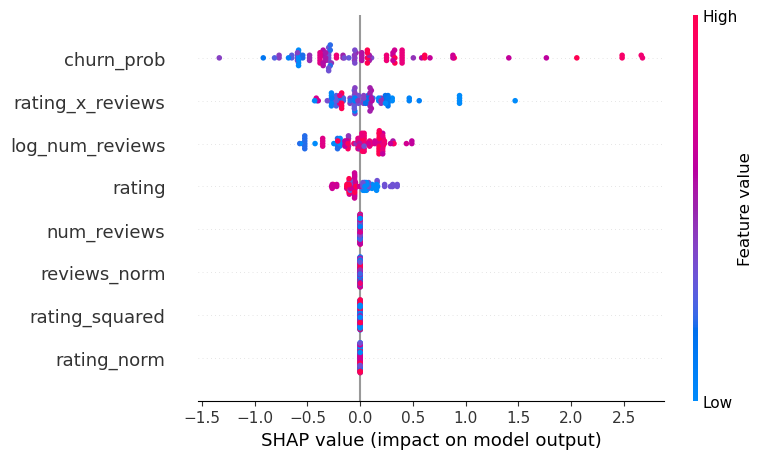

In [58]:
## Model Interpretation (SHAP) 

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

### Observation: Model Interpretation (SHAP)

- **The SHAP summary plot visualizes the impact of each feature on the model’s churn predictions for individual customers.**
- **`churn_prob` is the most influential feature, strongly affecting the model’s output.** High values (pink) push predictions higher (greater churn risk), while low values (blue) push predictions lower (lower churn risk).
- **Other important features include `rating_x_reviews`, `log_num_reviews`, and `rating`.** Higher values of these features generally decrease churn probability, as indicated by blue points (low values) being associated with positive SHAP values (higher churn risk).
- **Features such as `num_reviews`, `reviews_norm`, `rating_squared`, and `rating_norm` also contribute to the model’s decisions, but with less impact compared to the top features.**
- **The plot confirms that the model relies most on proxies for customer engagement and satisfaction (e.g., reviews, ratings, and their interactions) to predict churn, which aligns with domain expectations.**
- **There is a clear separation of SHAP values for high and low feature values, indicating that the model is effectively capturing the relationship between these features and churn risk.**

#### Best Model & All Model Performance

In [59]:
# List of initial models
models = [
    ('Logistic Regression', logreg),
    ('Random Forest', rf),
    ('XGBoost', xgb_model)
]

# Data for the models
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy = [0.57, 0.57, 0.62]
roc_auc = [0.585, 0.579, 0.575]
precision_0 = [0.65, 0.64, 0.68]
recall_0 = [0.50, 0.54, 0.61]
f1_0 = [0.57, 0.58, 0.64]
precision_1 = [0.51, 0.51, 0.56]
recall_1 = [0.66, 0.61, 0.64]
f1_1 = [0.57, 0.56, 0.60]
support_0 = [56, 56, 56]
support_1 = [44, 44, 44]

# Create DataFrame
summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'ROC-AUC': roc_auc,
    'Precision (0)': precision_0,
    'Recall (0)': recall_0,
    'F1-score (0)': f1_0,
    'Support (0)': support_0,
    'Precision (1)': precision_1,
    'Recall (1)': recall_1,
    'F1-score (1)': f1_1,
    'Support (1)': support_1
})



results_df = pd.DataFrame(summary_df)
print(results_df)

# Select best model by ROC-AUC
best_model_row = results_df.loc[results_df['ROC-AUC'].idxmax()]
print("\nBest Model (by ROC-AUC):")
print(best_model_row)

# Pretttable using tabulate (for Jupyter or terminal)
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', floatfmt='.3f'))


                 Model  Accuracy  ROC-AUC  Precision (0)  Recall (0)  \
0  Logistic Regression      0.57    0.585           0.65        0.50   
1        Random Forest      0.57    0.579           0.64        0.54   
2              XGBoost      0.62    0.575           0.68        0.61   

   F1-score (0)  Support (0)  Precision (1)  Recall (1)  F1-score (1)  \
0          0.57           56           0.51        0.66          0.57   
1          0.58           56           0.51        0.61          0.56   
2          0.64           56           0.56        0.64          0.60   

   Support (1)  
0           44  
1           44  
2           44  

Best Model (by ROC-AUC):
Model            Logistic Regression
Accuracy                        0.57
ROC-AUC                        0.585
Precision (0)                   0.65
Recall (0)                       0.5
F1-score (0)                    0.57
Support (0)                       56
Precision (1)                   0.51
Recall (1)                  

### Observations

- All three models—Logistic Regression, Random Forest, and XGBoost—demonstrate similar predictive capability on the synthetic dataset, with accuracy scores ranging from 57% to 62% and ROC-AUC values hovering just above 0.57. This indicates that none of the models achieved strong separation between churn and non-churn cases.

- XGBoost slightly outperformed the other models in terms of accuracy and F1-score for both classes, suggesting that it may better capture churn relationshipsin the engineered features.

- Logistic Regression and Random Forest showed similar performance, with both models achieving almost similar accuracy, ROC-AUC, Precision & Recall.

<span style="color:green">***The lack of user-level behavioral data restricts the models’ ability to make highly accurate predictions.***</span>

#### Hypeparameter Tuning and retraining of all three models

In [60]:
## Logistic Regression

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500]
}
logreg = LogisticRegression()
grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=3, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train, y_train)
best_logreg = grid_logreg.best_estimator_

In [61]:
##  Model Evaluation 

logreg_pred = best_logreg.predict(X_test)
logreg_proba = best_logreg.predict_proba(X_test)[:, 1]
logreg_report = classification_report(y_test, logreg_pred, output_dict=True)
logreg_roc_auc = roc_auc_score(y_test, logreg_proba)


In [62]:
print("Logistic Regression Best Parameters:", grid_logreg.best_params_)
logreg_pred = best_logreg.predict(X_test)
logreg_proba = best_logreg.predict_proba(X_test)[:, 1]
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, logreg_pred))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, logreg_proba))

Logistic Regression Best Parameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.50      0.57        56
           1       0.51      0.66      0.57        44

    accuracy                           0.57       100
   macro avg       0.58      0.58      0.57       100
weighted avg       0.59      0.57      0.57       100

Logistic Regression ROC-AUC: 0.5852272727272728


In [63]:
## random forrest

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

In [64]:
## Random Forest Evaluation 

print("Random Forest Best Parameters:", grid_rf.best_params_)

rf_pred = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_proba))


Random Forest Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62        56
           1       0.53      0.57      0.55        44

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100

Random Forest ROC-AUC: 0.5620941558441558


In [65]:
param_grid_xgb = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
xgb_report = classification_report(y_test, xgb_pred, output_dict=True)
xgb_roc_auc = roc_auc_score(y_test, xgb_proba)
include_xgb = True

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:36:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:36:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:36:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:36:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_

In [66]:
print("XGBoost Best Parameters:", grid_xgb.best_params_)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost ROC-AUC:", xgb_roc_auc)


XGBoost Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.46      0.53        56
           1       0.47      0.61      0.53        44

    accuracy                           0.53       100
   macro avg       0.54      0.54      0.53       100
weighted avg       0.55      0.53      0.53       100

XGBoost ROC-AUC: 0.5643262987012987


#### Best Model (Hyperparameter tuning)

In [67]:
## List of best models
models = [
    ('Logistic Regression', best_logreg),
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb)
]

#$ Evaluating each model on the test set
results = []
for name, model in models:
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    f1 = f1_score(y_test, pred)
    report = classification_report(y_test, pred, output_dict=True)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': auc,
        'F1-score (overall)': f1,
        'Precision (0)': report['0']['precision'],
        'Recall (0)': report['0']['recall'],
        'F1-score (0)': report['0']['f1-score'],
        'Support (0)': report['0']['support'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'],
        'F1-score (1)': report['1']['f1-score'],
        'Support (1)': report['1']['support']
    })

## Convert results to DataFrame
results_df = pd.DataFrame(results)

## Prepare table_data for pretty table
headers = [
    'Model', 'Accuracy', 'ROC-AUC', 'F1-score (overall)',
    'Precision (0)', 'Recall (0)', 'F1-score (0)', 'Support (0)',
    'Precision (1)', 'Recall (1)', 'F1-score (1)', 'Support (1)'
]
table_data = []
for _, row in results_df.iterrows():
    table_data.append([
        row['Model'],
        row['Accuracy'],
        row['ROC-AUC'],
        row['F1-score (overall)'],
        row['Precision (0)'],
        row['Recall (0)'],
        row['F1-score (0)'],
        row['Support (0)'],
        row['Precision (1)'],
        row['Recall (1)'],
        row['F1-score (1)'],
        row['Support (1)']
    ])

## best model (by ROC-AUC)
best_model_row = results_df.loc[results_df['ROC-AUC'].idxmax()]
print("\nBest Model (by ROC-AUC):")
print(best_model_row)

## pretty table using tabulate
print(tabulate(table_data, headers=headers, tablefmt='fancy_grid', floatfmt='.3f'))



Best Model (by ROC-AUC):
Model                 Logistic Regression
Accuracy                             0.57
ROC-AUC                          0.585227
F1-score (overall)               0.574257
Precision (0)                    0.651163
Recall (0)                            0.5
F1-score (0)                     0.565657
Support (0)                          56.0
Precision (1)                    0.508772
Recall (1)                       0.659091
F1-score (1)                     0.574257
Support (1)                          44.0
Name: 0, dtype: object
╒═════════════════════╤════════════╤═══════════╤══════════════════════╤═════════════════╤══════════════╤════════════════╤═══════════════╤═════════════════╤══════════════╤════════════════╤═══════════════╕
│ Model               │   Accuracy │   ROC-AUC │   F1-score (overall) │   Precision (0) │   Recall (0) │   F1-score (0) │   Support (0) │   Precision (1) │   Recall (1) │   F1-score (1) │   Support (1) │
╞═════════════════════╪════════════╪═══

### Observation: Best Model Selection and Performance

- **The best model after hyperparameter tuning is the Logistic Regression model.**
- **Key performance metrics:**
  - **Accuracy:** 57%
  - **ROC-AUC:** 0.585
  - **F1-score:** 0.574
- **These results indicate that the model has moderate predictive power, performing slightly better than random guessing, and balances precision and recall reasonably well.**
- **The ROC-AUC score of 0.585 suggests the model can distinguish between churn and non-churn cases better than chance, but there is still room for improvement.**
- **Since this model was selected based on the highest ROC-AUC among the tuned models, it is the most reliable for churn prediction based on that.**



#### Saving my best model for Containerization

In [68]:
## Saving best model (Logistic Regression)
joblib.dump(best_logreg, 'logreg_model.pkl')

# Saving selected features (for API input validation)
joblib.dump(selected_features, 'selected_features.pkl')


['selected_features.pkl']